## General purpouse analysis functions

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import os
from numpy.polynomial import Polynomial
from scipy.signal import butter, filtfilt
import pandas as pd

############################################ Functions ############################################

def csv2array(file_name, folder_name, column_x_index, column_y_index, starting_row, Delimiter):
    """
    Read a CSV file stored on a subfolder and extract data from two columns.

    @param file_name: String containing the name for the CSV file. Warning: Do include the .csv extension i.e. file_name = "Test.csv"
    @param folder_name: String containing the name for the subfloder containing said CSV file (Check the expected folder structure below).
    @param column_x_index: The index of the first column to extract, A=0, B=1....
    @param column_y_index: The index of the second column to extract.
    @param starting_row: The row index to start reading data from, row=1, 2...
    @param Delimiter: Separator between columns

    @return: A list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @note:Expected folder structure

    folder/
    ├── notebook.ipynb
    └── subfolder/
        ├── file1.csv
        ├── file2.csv
        └── file3.csv


    @Warning: If you copy the string from Windows file browser and dont want to change backslash for '/' read it as raw by writing an 'r' before the string path like so: 'csv2array(r"C:...'



    """
    
    # Arrays to store x and y values, in that order
    column_x_values = []
    column_y_values = []

    # Fix row indexing
    starting_row = starting_row - 1

    # Dynamicaly read the path to the file
    #folder_path = os.path.dirname(os.path.abspath("Analisis_Figuras_Paper.ipynb"))
    folder_path = os.getcwd()
    CSV_PATH = os.path.join(folder_path, folder_name, file_name)


    # Read the CSV file. 'with' statement handles closing the file correctly without using 'close'.
    with open(CSV_PATH, 'r') as file:
        reader = csv.reader(file, delimiter = Delimiter)
        
        # Skip rows until the starting row
        for _ in range(starting_row):

            # next runs through an iterable
            next(reader)
        
        # Read rows until an empty cell is encountered
        for row in reader:
            if not row[column_x_index] or not row[column_y_index]:
                break  # Stop reading if either column has an empty cell
            
            # Values are read as strings, change commas for dots before casting to floats
            value_x = row[column_x_index].replace(',', '.')
            value_y = row[column_y_index].replace(',', '.')

            # Cast to floats
            column_x_values.append(float(value_x))
            column_y_values.append(float(value_y))

    # Also return a string containing the name of the data
    file_name = os.path.basename(CSV_PATH)
    file_name = os.path.splitext(file_name)[0]

    
    # Return the lists as arrays
    return [np.array(column_x_values), np.array(column_y_values), file_name]



def filter_data(order, cutoff_freq, data, Btype='low', graph=True):
    """
    Read a 2D array, design a butterworth filter, apply it and visualize it.

    This function is meant to be used in succession to csv2array, it applies a filter without delay and graphs the raw signals spectrum as well as the filtered one.
    This is done to aid in the design of the filter.

    @param order: order of the filter, since the filter is applied twice to achieve zero phase shift this is actualy half of the final order.
    @param cutoff_freq: cutoff frequency in Hz for the filter
    @param data: a list containing 2 arrays like so: [x, y]
    @param Btype: Type of filter for scipy's butter function
    @param graph: Boolean to decide wether to graph the results or not

    @return: a list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @Warning: Samples should be evenly spaced in time.
    """

    x_raw = data[0]
    y_raw = data[1]


    ################# Design Filter #########################################################################
    # Sampling frequency in Hz
    sampling_freq = 1 / (x_raw[1] - x_raw[0])

    # Convert cutoff frequency to a normalized value
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth filter
    b, a = butter(order, normalized_cutoff, btype=Btype, analog=False, output='ba')

    # Apply the filter using filtfilt to achieve zero-phase filtering
    y_filt = filtfilt(b, a, y_raw)


    ################# FFT #################################################################################
    # Compute the FFT of both the raw and filtered signals
    y_fft_raw = np.fft.fft(y_raw)
    y_fft_filt = np.fft.fft(y_filt)

    # Compute frequency array, same length and with sampling interval d=Delta x
    freq = np.fft.fftfreq(len(y_raw), d=(x_raw[1] - x_raw[0]))

    # Find the indices corresponding to the desired frequency range (0 to 1.0)
    freq_indices = np.where(np.logical_and(freq >= 0, freq <= 1000))



    ################# Plot ################################################################################
    # Clear the existing subplot and plot the FFT
    if (graph):
        # Create a figure with two subplots
        fig, axs = plt.subplots(2, 1)
        ax = axs[0]
        ax.clear()
        ax.plot(freq[freq_indices], np.abs(y_fft_raw[freq_indices]), linewidth=0.5, alpha=0.25, color="black")
        ax.plot(freq[freq_indices], np.abs(y_fft_filt[freq_indices]), linewidth=0.5, color="blue")
        ax.set_ylabel('Amplitude')
        ax.set_title('FFT of '+str(data[2]))
        ax.set_xlabel('Frequency [Hz]')

        # Plot raw vs filtered data
        ax = axs[1]
        ax.scatter(x_raw, y_raw, s=1, alpha=1, color="k")
        ax.plot(x_raw, y_filt, color="blue", linewidth=1)

        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.6)

        plt.show()

    return [x_raw, y_filt, data[2]]


C:\Users\Guille\AppData\Local\Temp\ipykernel_21672\1628250083.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Read Origin txt data

In [80]:
num_header_lines = 3  # Set the number of header lines to skip

# Open the file for reading
with open('Test7_02.txt', 'r') as file:
    # Skip the header lines
    for _ in range(num_header_lines):
        next(file)
    
    # Now, you can read and process the data
    for line in file:
        # Process each line of data as needed
        print(line.strip())  # Print the line after stripping newline characters


FileNotFoundError: [Errno 2] No such file or directory: 'Test7_02.txt'

### Read CSV data

In [ ]:
BICPDMS000ROI = csv2array(file_name="BICPDMS000ROI.csv", folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')
BicStrycSf501 = csv2array(file_name="BicStrycSf501.csv", folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')

# Append to each list of data their corresponding units
BicStrycSf501.append(r'$\mu_{0} H$ [nT]')
BICPDMS000ROI.append(r'$Ca^{2+}$ [a.u.]')

# Store into one array for iterations
Data = [(BicStrycSf501), (BICPDMS000ROI)]


## Filter Data

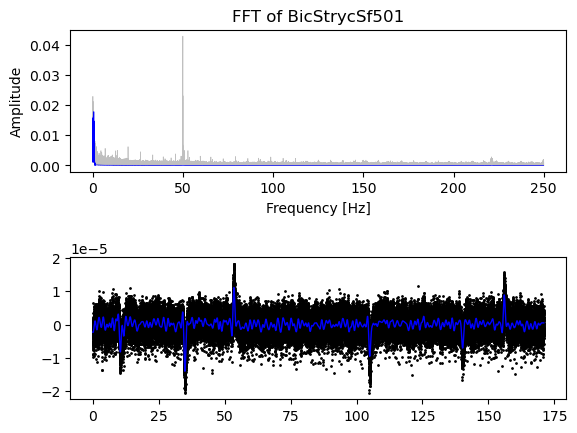

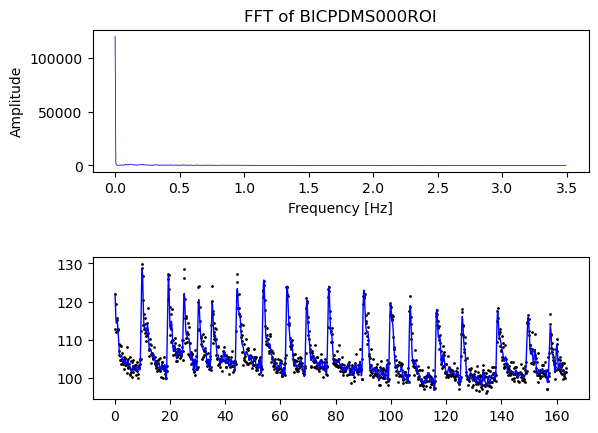

In [ ]:
for data in Data:
    filter_data(order=7, cutoff_freq=1, data=data, Btype='low', graph=True)

### Bandpass example

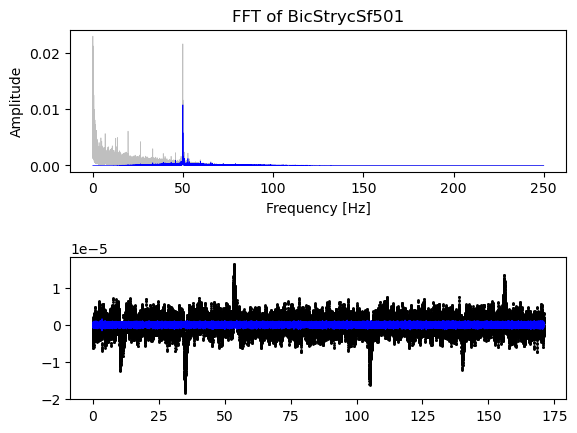

In [ ]:
# Make first iteration "non-verbose"
data_LP_filt = filter_data(order=2, cutoff_freq=50, data=Data[0], Btype='low', graph=False)
data_BP_filt = filter_data(order=2, cutoff_freq=50, data=data_LP_filt, Btype='high')

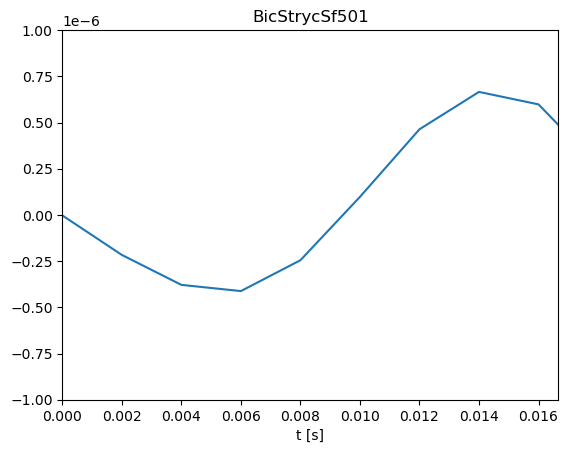

In [ ]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(data_BP_filt[0], data_BP_filt[1])

# Customize the plot
ax.set_xlabel('t [s]')
#ax.set_ylabel('')
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)

# Display the figure
plt.show()

### Analysis of Photodiode response curves + Transmitance

#### Extract data

In [ ]:
# Get data from photodiodes spectral responsivity
Blue = csv2array(file_name='Blue.csv', folder_name="Data", column_x_index=0, column_y_index=1, starting_row=1, Delimiter=';')
Green = csv2array(file_name='Green.csv', folder_name="Data", column_x_index=0, column_y_index=1, starting_row=1, Delimiter=';')
Red = csv2array(file_name='Red.csv', folder_name="Data", column_x_index=0, column_y_index=1, starting_row=1, Delimiter=';')

# Get data from LED relative emission
Source_Rel_Em = csv2array(file_name='LED_Relative_Emission.csv', folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')

# Store data for all transmittance curves in an array
# Initialize an empty structured array where each element can store two arrays corresponding to wavelength and transmittance. It also stores info related to said experiment
data_type = [('wavelength', object), ('transmittance', object), ('info', float)]

# Initialize an empty structured array
Transmittance = np.array([], dtype=data_type)

# Iteratively read all 9 transmittance curves from CSV and append them to the Transmitance array
for i in range(9):
    # Read transmittance curve i and wavelength
    transmittance_buff = csv2array(file_name='Transmittance.csv', folder_name="Data", column_x_index=10, column_y_index=i, starting_row=3, Delimiter=';')
    info = float(2 * i)  # Stores the minute at which the measurement was taken 

    # Append the pair of arrays to the structured array
    Transmittance = np.append(Transmittance, np.array([(transmittance_buff[0], transmittance_buff[1], info)], dtype=data_type))

### Obtain theoretical response of photodiodes

In [ ]:
################################################## Analysis ##################################################

# Store in an array to iterate
Responsivities = np.array([Red, Green, Blue])
Traces = [[], [], []]
Spectras_at_PD = np.array([], dtype=data_type)
hack = True

for j in range(len(Responsivities)):

    wavelengths1 = Responsivities[j][0]  # Wavelengths for spectral responsivity for the photodiode
    spectral_responsivity = Responsivities[j][1]  # Spectral Responsivity A/W for the photodiode

    iterations = len(Transmittance)

    for n in range(iterations):
        wavelengths0 = Source_Rel_Em[0]
        source_aligned = Source_Rel_Em[1]

        wavelengths2 = Transmittance['wavelength'][n]  # Wavelengths in nanometers for the transmittance
        transmittance_aligned = Transmittance['transmittance'][n]  # Transmitance of the medium

        # Generate an array of wavelengths encasing all 3 curves
        common_wavelengths = np.linspace(min(min(wavelengths0), min(wavelengths1), min(wavelengths2)), max(max(wavelengths0), max(wavelengths1), max(wavelengths2)), 100)

        # Since sampled data is missaligned generate new data by interpolation at the common wavelengths
        source_aligned = np.interp(common_wavelengths, wavelengths0, source_aligned)
        transmittance_aligned = np.interp(common_wavelengths, wavelengths2, transmittance_aligned)
        responsivity_aligned = np.interp(common_wavelengths, wavelengths1, spectral_responsivity)

        # Find the response of the photodiode to the light source with wavelength dependency
        spectra_at_PD = source_aligned * transmittance_aligned 
        current_output = spectra_at_PD * responsivity_aligned

        # Integrate the result with respect to wavelength wavelength using the trapezoidal rule to find the final contribution
        PD_response = np.trapz(current_output, common_wavelengths)

        # Finaly store all calculated data to plot later on
        Traces[j].append(PD_response)
        Transmittance['wavelength'][n] = common_wavelengths
        Transmittance['transmittance'][n] = transmittance_aligned
        Source_Rel_Em[0] = common_wavelengths
        Source_Rel_Em[1] = source_aligned
        

        # Only store on the first run, subsequent runs redo this calculation again
        if(hack):
            Spectras_at_PD = np.append(Spectras_at_PD, np.array([(common_wavelengths, spectra_at_PD, info)], dtype=data_type))

    Responsivities[j][0] = common_wavelengths
    Responsivities[j][1] = responsivity_aligned

    hack = False


# Generate time array
time = []
for m in range(9):
    time.append(m*2)


# "Pinch" data
for h in range(len(Traces)):
    Traces[h] = Traces[h] / Traces[h][0]



C:\Users\Usuario\AppData\Local\Temp\ipykernel_14580\651431581.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Responsivities = np.array([Red, Green, Blue])


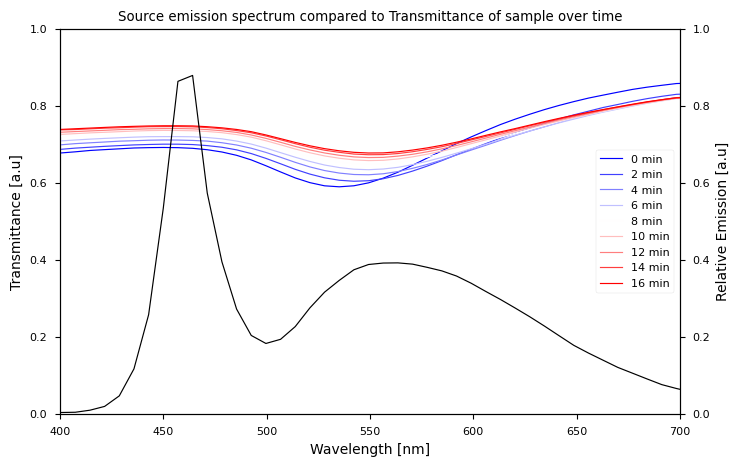

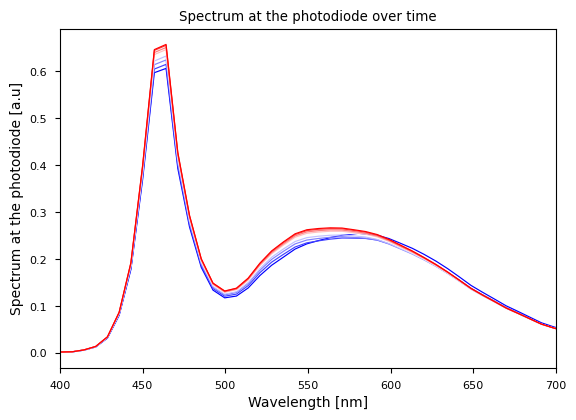

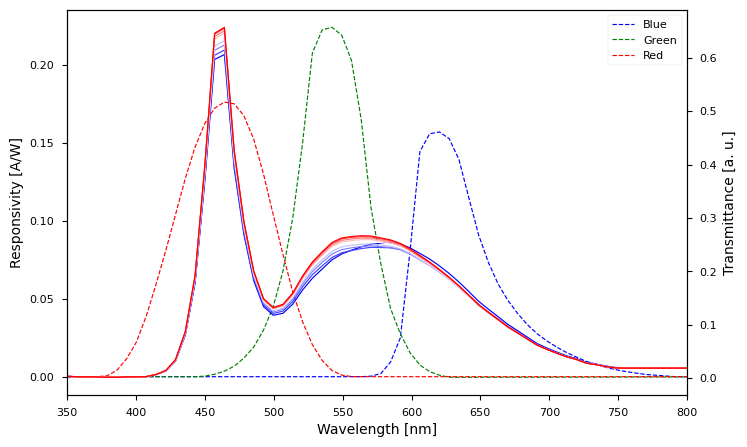

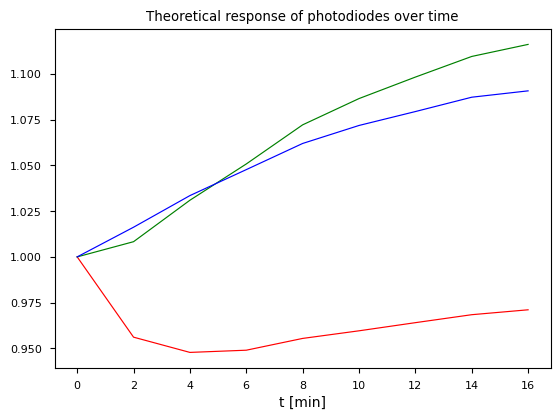

In [ ]:
###################################################### Graph style #######################################################
colors = plt.cm.bwr(np.linspace(0, 1, len(Transmittance)))  # Choose a colormap (viridis in this case)
plt.style.use('seaborn-v0_8-paper')
user_linewidth = 0.85

######################################################## Figure 1 ########################################################
# Shows both the spectra of the source and the transmittance of the sample
fig1, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()

# Plot your additional data on the new figure (ax3)
iterations = len(Transmittance)
for n in range(iterations):
    ax2.plot(Transmittance['wavelength'][n], Transmittance['transmittance'][n], label=str(int(Transmittance['info'][n]))+' min'
             , linewidth = user_linewidth, color = colors[n])

ax2.plot(Source_Rel_Em[0], Source_Rel_Em[1], linewidth = user_linewidth, color='black')
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)

# The alignment process creates fake data at the extremes so we will be careful to plot only the range of real data
ax1.set_xlim(400, 700)
ax2.set_xlim(400, 700)
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('Transmittance [a.u]')
ax2.set_ylabel('Relative Emission [a.u]')
ax1.set_title('Source emission spectrum compared to Transmittance of sample over time')
ax2.legend()

######################################################## Figure 2 ########################################################
# Figure showing light spectra at photodiode
fig2 = plt.figure()

# Add a subplot
ax3 = fig2.add_subplot(111)

# Plot the data
for n in range(len(Spectras_at_PD)):
    ax3.plot(Spectras_at_PD['wavelength'][n], Spectras_at_PD['transmittance'][n], linewidth = user_linewidth, color = colors[n])

# Customize the plot
ax3.set_xlim(400, 700)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('Spectrum at the photodiode [a.u]')
#ax.set_ylabel('')
ax3.set_title('Spectrum at the photodiode over time')

######################################################## Figure 3 ########################################################
# Create the original twin figure
fig3, ax4 = plt.subplots(figsize=(8, 5))
ax5 = ax4.twinx()

# Plot data on the original twin figure (as in your provided code)
ax4.plot(Responsivities[0][0], Responsivities[0][1], color='blue', label='Blue', linewidth = user_linewidth, linestyle='dashed')
ax4.plot(Responsivities[1][0], Responsivities[1][1], color='green', label='Green', linewidth = user_linewidth, linestyle='dashed')
ax4.plot(Responsivities[2][0], Responsivities[2][1], color='red', label='Red', linewidth = user_linewidth,linestyle='dashed')

iterations = len(Transmittance)
for n in range(iterations):
    ax5.plot(Spectras_at_PD['wavelength'][n], Spectras_at_PD['transmittance'][n], linewidth = user_linewidth, color = colors[n])

ax4.set_xlabel('Wavelength [nm]')
ax4.set_ylabel('Responsivity [A/W]')
ax5.set_ylabel('Transmittance [a. u.]')
#ax4.set_ylim(0, 0.05 + max(Green[1]))
#ax2.set_ylim(0.4, 0.9)
ax4.set_xlim(350, 800)
ax4.legend()
'''
ax4.set_xticks([])
ax5.set_xticks([])
ax4.set_yticks([])
ax5.set_yticks([])

ax4.set_yticks(np.linspace(min(Green[1]), max(Green[1]), 5))
ax5.set_yticks(np.linspace(min(Spectras_at_PD['transmittance'][0]), max(Spectras_at_PD['transmittance'][0]), 5))
'''

######################################################## Figure 4 ########################################################
# Final figure with evolution of traces over time
fig4 = plt.figure()

# Add a subplot
ax6 = fig4.add_subplot(111)

# Plot the data
ax6.plot(time, Traces[0], linewidth = user_linewidth, color='red')
ax6.plot(time, Traces[1], linewidth = user_linewidth, color='green')
ax6.plot(time, Traces[2], linewidth = user_linewidth, color='blue')

# Customize the plot
ax6.set_xlabel('t [min]')
#ax.set_ylabel('')
ax6.set_title('Theoretical response of photodiodes over time')

# Display the fiugres
plt.show()

### The story of this figure

The papers figure is composed of all of the above, it's main objective is double. First it is a study on wether our "poor man" spectrophotometer will be able to measure the phenomena we are after, the problem is we want to analyze the spectra of multiple samples at once and with a relatively high sampling rate (~1S/s), this would call for 10 photospectrometers or at least increase the complexity of the device by adding a light multiplexing system into one spectrometer, we wanted to see if only 3 photodiodes (RGB) would be enough to capture the change in spectra of the aggregated Au NP when lit up by a white LED. This spectrometer would be composed og a inhomogeneous light source and a spectrum of 3 data points only so it begs the question, will the precission be enough to meet the requirements?

To test it we performed the simulation above, where the light spectra of the white LED and the Responsivity of the RGB diodes was extracted from their respective datsheets, the spectra of the NP was sampled over 18 minutes with an interval of 2 minutes and a bandwidth of 3nm, this provided a good measure for the spectra of the NP over time. The only thing left to do was compute all data, the spectra of light outside after going through the sample is computed as the product of the source spectra and the transmissitance of the NP, finaly the response of the photodiodes is computed as the product of the responsivity curves of each photodiode and the spectra at the photodiode, this final spectra is integrated with respect to the wavelength to find the response of each photodiode over time. All three responses are pinched to the same initial point after dividing them by the first value of their list.

This final graph shows that the system is capable of capturing the change in spectra.

In [ ]:

# Dynamicaly read the path to the file
folder_path = os.getcwd()
folder_name = "Data"
file_name = "Spectral_Response.csv"
CSV_PATH = os.path.join(folder_path, folder_name, file_name)

# Read the CSV file with the correct delimiter (semicolon in this case)
df = pd.read_csv(CSV_PATH, sep=';')

# Replace empty strings with NaN
df = df.replace('', pd.NA)

# Drop columns that contain only missing values (NaN)
df = df.dropna(axis=1, how='all')

df

,Blue,Unnamed: 1,Green,Unnamed: 4,Red,Unnamed: 7
0,wavelength [nm],Photosensitivity [A/W],wavelength [nm],Photosensitivity [A/W],wavelength [nm],Photosensitivity [A/W]
1,2.21E-07,0,2.93E-07,-0.000430622,2.97E-07,-0.000421053
2,2.43E-07,0,3.06E-07,9.56938E-05,3.28E-07,-0.000421053
3,2.65E-07,0,3.22E-07,-0.000430622,3.55E-07,0.000105263
4,2.93E-07,0.000526316,3.38E-07,9.56938E-05,3.84E-07,0.000105263
...,...,...,...,...,...,...
102,NaN,NaN,8.07E-07,-0.000956938,NaN,NaN
103,NaN,NaN,8.33E-07,-0.000430622,NaN,NaN
104,NaN,NaN,8.62E-07,-0.000430622,NaN,NaN
105,NaN,NaN,8.89E-07,-0.000956938,NaN,NaN


In [ ]:
################################# Dict to excel #################################

# First create a dictionary for the data that we want to write into an excel
df_dict_0 = {}
df_dict_0['Wavelength [nm]'] = Spectras_at_PD['wavelength'][0]
df_dict_0['Source Relative Emision [a.u.]'] = Source_Rel_Em[1]

iterations = len(Transmittance)
for n in range(iterations):
    Transmittance_at_timestamp = 'Transmittance at timestamp ' + str(n*2) + ' min [a.u.]'
    df_dict_0[Transmittance_at_timestamp] = Transmittance['transmittance'][n]

iterations = len(Transmittance)
for n in range(iterations):
    Spectra_at_PD_at_timestamp = 'Spectra at PD at timestamp ' + str(n*2) + ' min [a.u.]'
    df_dict_0[Spectra_at_PD_at_timestamp] = Spectras_at_PD['transmittance'][n]

df_dict_0['PDs Blue Responsivity [A/W]'] = Responsivities[0][1]
df_dict_0['PDs Green Responsivity [A/W]'] = Responsivities[1][1]
df_dict_0['PDs Red Responsivity [A/W]'] = Responsivities[2][1]

# Repeat for data corresponding to second sheet
df_dict_1 = {}
df_dict_1['Time [s]'] = time
df_dict_1['Blue Spectra [a.u.]'] = Traces[0]
df_dict_1['Green Spectra [a.u.]'] = Traces[1]
df_dict_1['Red Spectra [a.u.]'] = Traces[2]

# Then cast the, to pandas dataframes
df_0 = pd.DataFrame(df_dict_0)
df_1 = pd.DataFrame(df_dict_1)

# Write to excel dynamicaly
file = "Spectra_Simulation.xlsx"
subfolder = 'Output'
directory_folder = os.getcwd()
file_path = os.path.join(directory_folder, subfolder, file)

sheetname_0 = "Calculations"
sheetname_1 = "Results"


# Create an ExcelWriter object
with pd.ExcelWriter(file_path) as writer:
    # Write each dataframe to a different sheet using the ExcelWriter
    df_0.to_excel(writer, sheet_name=sheetname_0, index=False)
    df_1.to_excel(writer, sheet_name=sheetname_1, index=False)

### Plot figures for Magnetic Sensor Detectivity Setup presentation

#### Read Datasheet data from CSVs

In [4]:

# Dynamicaly read the path to the file
folder_path = os.getcwd()
folder_name = "Data"
file_name_0 = "HMC1001_noise.csv"
file_name_1 = "SR560_noise.csv"
file_name_2 = "TMR9003_noise.csv"
file_name_3 = "TMR9112_noise.csv"
file_name_4 = "INA217_G10_noise.csv"
file_name_5 = "INA217_G100_noise.csv"
file_name_9 = "INA_Short.csv"
file_name_10 = "INA_20Meg.csv"
CSV_PATH_0 = os.path.join(folder_path, folder_name, file_name_0)
CSV_PATH_1 = os.path.join(folder_path, folder_name, file_name_1)
CSV_PATH_2 = os.path.join(folder_path, folder_name, file_name_2)
CSV_PATH_3 = os.path.join(folder_path, folder_name, file_name_3)
CSV_PATH_4 = os.path.join(folder_path, folder_name, file_name_4)
CSV_PATH_5 = os.path.join(folder_path, folder_name, file_name_5)
CSV_PATH_9 = os.path.join(folder_path, folder_name, file_name_9)
CSV_PATH_10 = os.path.join(folder_path, folder_name, file_name_10)

# Read the CSV file with the correct delimiter (semicolon in this case)
HMC1001_df = pd.read_csv(CSV_PATH_0, sep='\t')
SR560_df = pd.read_csv(CSV_PATH_1, sep='\t')
TMR9003_df = pd.read_csv(CSV_PATH_2, sep='\t')
TMR9112_df = pd.read_csv(CSV_PATH_3, sep='\t')
INA217_G10_df = pd.read_csv(CSV_PATH_4, sep='\t')
INA217_G100_df = pd.read_csv(CSV_PATH_5, sep='\t')
INAShort_df = pd.read_csv(CSV_PATH_9, sep=',')
INA22Meg_df = pd.read_csv(CSV_PATH_10, sep=',')

# Replace empty strings with NaN
HMC1001_df = HMC1001_df.replace('', pd.NA)
SR560_df = SR560_df.replace('', pd.NA)
TMR9003_df = TMR9003_df.replace('', pd.NA)
TMR9112_df = TMR9112_df.replace('', pd.NA)
INA217_G10_df = INA217_G10_df.replace('', pd.NA)
INA217_G100_df = INA217_G100_df.replace('', pd.NA)
INAShort_df = INAShort_df.replace('', pd.NA)
INA22Meg_df = INA22Meg_df.replace('', pd.NA)

# Drop columns that contain only missing values (NaN)
HMC1001_df = HMC1001_df.dropna(axis=1, how='all')
SR560_df = SR560_df.dropna(axis=1, how='all')
TMR9003_df = TMR9003_df.dropna(axis=1, how='all')
TMR9112_df = TMR9112_df.dropna(axis=1, how='all')
INA217_G10_df = INA217_G10_df.dropna(axis=1, how='all')
INA217_G100_df = INA217_G100_df.dropna(axis=1, how='all')
INAShort_df = INAShort_df.dropna(axis=1, how='all')
INA22Meg_df = INA22Meg_df.dropna(axis=1, how='all')

# Convert decimal commas to decimal points
HMC1001_df["Frec"] = [float(str(i).replace(",", ".")) for i in HMC1001_df["Frec"]]
HMC1001_df["PSD"] = [float(str(i).replace(",", ".")) for i in HMC1001_df["PSD"]]
SR560_df["Frec"] = [float(str(i).replace(",", ".")) for i in SR560_df["Frec"]]
SR560_df["PSD"] = [float(str(i).replace(",", ".")) for i in SR560_df["PSD"]]
TMR9003_df["Frec"] = [float(str(i).replace(",", ".")) for i in TMR9003_df["Frec"]]
TMR9003_df["PSD"] = [float(str(i).replace(",", ".")) for i in TMR9003_df["PSD"]]
TMR9112_df["Frec"] = [float(str(i).replace(",", ".")) for i in TMR9112_df["Frec"]]
TMR9112_df["PSD"] = [float(str(i).replace(",", ".")) for i in TMR9112_df["PSD"]]
INA217_G10_df["Frec"] = [float(str(i).replace(",", ".")) for i in INA217_G10_df["Frec"]]
INA217_G10_df["PSD"] = [float(str(i).replace(",", ".")) for i in INA217_G10_df["PSD"]]
INA217_G100_df["Frec"] = [float(str(i).replace(",", ".")) for i in INA217_G100_df["Frec"]]
INA217_G100_df["PSD"] = [float(str(i).replace(",", ".")) for i in INA217_G100_df["PSD"]]
INAShort_df["Frec"] = [float(str(i).replace(",", ".")) for i in INAShort_df["Frec"]]
INAShort_df["PSD"] = [float(str(i).replace(",", ".")) for i in INAShort_df["PSD"]]
INA22Meg_df["Frec"] = [float(str(i).replace(",", ".")) for i in INA22Meg_df["Frec"]]
INA22Meg_df["PSD"] = [float(str(i).replace(",", ".")) for i in INA22Meg_df["PSD"]]

INA22Meg_df

,Frec,PSD
0,0.0,1.520000e-04
1,1.0,1.120000e-08
2,2.0,8.010000e-09
3,3.0,5.930000e-09
4,4.0,5.580000e-09
...,...,...
38395,38400.0,6.020000e-09
38396,38400.0,5.350000e-09
38397,38400.0,5.100000e-09
38398,38400.0,5.170000e-09


#### Read Simulation data from txt

In [5]:

# Dynamicaly read the path to the file
file_name_6 = "HMC1001Sim.txt"
file_name_8 = "InputNoiseWholeChaingINAG100INAandSRTheoretical.txt"
CSV_PATH_6 = os.path.join(folder_path, folder_name, file_name_6)
CSV_PATH_8 = os.path.join(folder_path, folder_name, file_name_8)

# Read the CSV file with the correct delimiter (semicolon in this case)
HMC1001Sim_df = pd.read_csv(CSV_PATH_6, sep='\t')
VinTheorSim_df = pd.read_csv(CSV_PATH_8, sep='\t')

# Rename Headers to match those from CSVs
HMC1001Sim_df.columns = ["Frec", "PSD"]
VinTheorSim_df.columns = ["Frec", "PSD"]

VinTheorSim_df


,Frec,PSD
0,0.100000,3.660418e-08
1,0.102329,3.618663e-08
2,0.104713,3.577387e-08
3,0.107152,3.536586e-08
4,0.109648,3.496254e-08
...,...,...
496,9120.108394,2.153216e-09
497,9332.543008,2.153139e-09
498,9549.925860,2.153063e-09
499,9772.372210,2.152989e-09


#### Read data to calculate input noise from stages

In [6]:

# Dynamicaly read the path to the file
file_name_7 = "ADC_Short.csv"
file_name_8 = "ADC_High_R.csv"
CSV_PATH_7 = os.path.join(folder_path, folder_name, file_name_7)
CSV_PATH_8 = os.path.join(folder_path, folder_name, file_name_8)

# Read the CSV file with the correct delimiter (semicolon in this case)
ADC_Short_df = pd.read_csv(CSV_PATH_7, sep=',')
ADC_High_R_df = pd.read_csv(CSV_PATH_8, sep=',')

# Replace empty strings with NaN
ADC_Short_df = ADC_Short_df.replace('', pd.NA)
ADC_Short_df = ADC_Short_df.replace('', pd.NA)


# Drop columns that contain only missing values (NaN)
ADC_Short_df = ADC_Short_df.dropna(axis=1, how='all')
ADC_High_R_df = ADC_High_R_df.dropna(axis=1, how='all')

# Convert decimal commas to decimal points
ADC_Short_df["Frec"] = [float(str(i).replace(",", ".")) for i in ADC_Short_df["Frec"]]
ADC_Short_df["PSD"] = [float(str(i).replace(",", ".")) for i in ADC_Short_df["PSD"]]
ADC_High_R_df["Frec"] = [float(str(i).replace(",", ".")) for i in ADC_High_R_df["Frec"]]
ADC_High_R_df["PSD"] = [float(str(i).replace(",", ".")) for i in ADC_High_R_df["PSD"]]
VinTheorSim_df["Frec"] = [float(str(i).replace(",", ".")) for i in VinTheorSim_df["Frec"]]
VinTheorSim_df["PSD"] = [float(str(i).replace(",", ".")) for i in VinTheorSim_df["PSD"]]

VinTheorSim_df

,Frec,PSD
0,0.100000,3.660418e-08
1,0.102329,3.618663e-08
2,0.104713,3.577387e-08
3,0.107152,3.536586e-08
4,0.109648,3.496254e-08
...,...,...
496,9120.108394,2.153216e-09
497,9332.543008,2.153139e-09
498,9549.925860,2.153063e-09
499,9772.372210,2.152989e-09


#### Analyze wether we can measure without the homebrewed INA stage

In [7]:
# Store dataframes into lists, first list is for frequencies, second for PSDs
HMC1001_arr = [[], []]
SR560_arr = [[], []]
TMR9003_arr = [[], []]
TMR9112_arr = [[], []]
INA217_G10_arr = [[], []]
INA217_G100_arr = [[], []]
HMC1001Sim_arr = [[], []]
ADC_Short_arr = [[], []]
ADC_High_R_arr = [[], []]
VinTheorSim_arr = [[], []]
INAShort_arr = [[], []]
INA22Meg_arr = [[], []]

# Cast strings to floats
HMC1001_arr[0], HMC1001_arr[1] = HMC1001_df["Frec"].values, HMC1001_df["PSD"].values
SR560_arr[0], SR560_arr[1] = SR560_df["Frec"].values, SR560_df["PSD"].values
TMR9003_arr[0], TMR9003_arr[1] = TMR9003_df["Frec"].values, TMR9003_df["PSD"].values
TMR9112_arr[0], TMR9112_arr[1] = TMR9112_df["Frec"].values, TMR9112_df["PSD"].values
INA217_G10_arr[0], INA217_G10_arr[1] = INA217_G10_df["Frec"].values, INA217_G10_df["PSD"].values
INA217_G100_arr[0], INA217_G100_arr[1] = INA217_G100_df["Frec"].values, INA217_G100_df["PSD"].values
HMC1001Sim_arr[0], HMC1001Sim_arr[1] = HMC1001Sim_df["Frec"].values, HMC1001Sim_df["PSD"].values
ADC_Short_arr[0], ADC_Short_arr[1] = ADC_Short_df["Frec"].values, ADC_Short_df["PSD"].values
ADC_High_R_arr[0], ADC_High_R_arr[1] = ADC_High_R_df["Frec"].values, ADC_High_R_df["PSD"].values
VinTheorSim_arr[0], VinTheorSim_arr[1] = VinTheorSim_df["Frec"].values, VinTheorSim_df["PSD"].values
INAShort_arr[0], INAShort_arr[1] = INAShort_df["Frec"].values, INAShort_df["PSD"].values
INA22Meg_arr[0], INA22Meg_arr[1] = INA22Meg_df["Frec"].values, INA22Meg_df["PSD"].values

In [8]:
# Align data

# Generate an array of N frequencies encasing all curves
N = 5000
common_freqs = np.linspace(min(min(SR560_arr[0]), min(HMC1001_arr[0])), max(max(SR560_arr[0]), max(HMC1001_arr[0])), N)

# Since sampled data is missaligned generate new data by interpolation at the common frequencies
SR560_aligned = np.interp(common_freqs, HMC1001_arr[0], HMC1001_arr[1])
HMC1001_aligned = np.interp(common_freqs, SR560_arr[0], SR560_arr[1])
TMR9003_aligned = np.interp(common_freqs, TMR9003_arr[0], TMR9003_arr[1])
TMR9112_aligned = np.interp(common_freqs, TMR9112_arr[0], TMR9112_arr[1])
INA217_G10_aligned = np.interp(common_freqs, INA217_G10_arr[0], INA217_G10_arr[1])
INA217_G100_aligned = np.interp(common_freqs, INA217_G100_arr[0], INA217_G100_arr[1])
HMC1001Sim_aligned = np.interp(common_freqs, HMC1001Sim_arr[0], HMC1001Sim_arr[1])
ADC_Short_aligned = np.interp(common_freqs, ADC_Short_arr[0], ADC_Short_arr[1])
ADC_High_R_aligned = np.interp(common_freqs, ADC_High_R_arr[0], ADC_High_R_arr[1])
VinTheorSim_aligned = np.interp(common_freqs, VinTheorSim_arr[0], VinTheorSim_arr[1])
INAShort_aligned = np.interp(common_freqs, INAShort_arr[0], INAShort_arr[1])
INA22Meg_aligned = np.interp(common_freqs, INA22Meg_arr[0], INA22Meg_arr[1])


In [9]:
# Gain correction for high impedance measurements
INA22Meg_aligned = 1.37 * INA22Meg_aligned
ADC_High_R_aligned = 1.37 *ADC_High_R_aligned

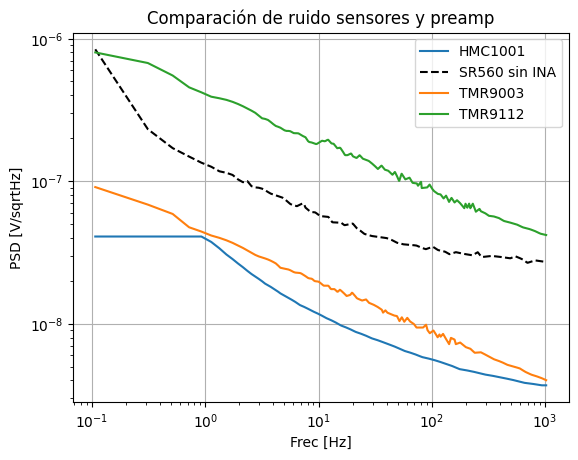

In [10]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(common_freqs, HMC1001_aligned, label='HMC1001')
ax.plot(common_freqs, SR560_aligned, color='k', linestyle="dashed", label='SR560 sin INA')
#ax.plot(common_freqs, INA217_G10_aligned, color='k', linestyle="dashed", label='INA217 G=10')
#ax.plot(common_freqs, INA217_G100_aligned, color='r', linestyle="dashed", label='INA217 G=100')
ax.plot(common_freqs, TMR9003_aligned, label='TMR9003')
ax.plot(common_freqs, TMR9112_aligned, label='TMR9112')

# Log plot
ax.set_xscale('log')
ax.set_yscale('log')

# Customize the plot
ax.set_xlabel('Frec [Hz]')
ax.set_ylabel('PSD [V/sqrtHz]')
ax.set_title('Comparación de ruido sensores y preamp')
ax.grid()
'''
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)
'''
ax.legend()

# Display the figure
plt.show()

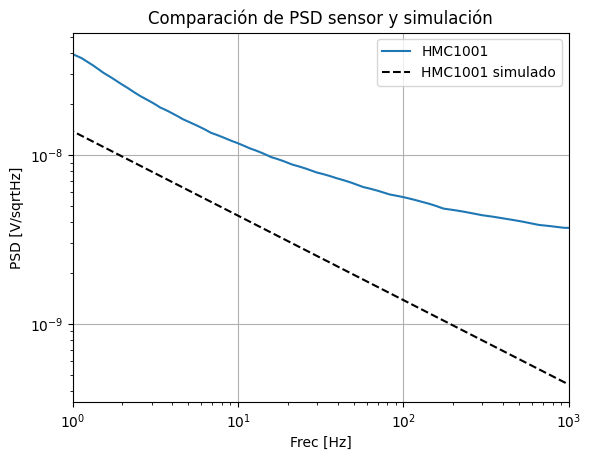

In [11]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(common_freqs, HMC1001_aligned, label='HMC1001')
ax.plot(common_freqs, HMC1001Sim_aligned, color='k', linestyle="dashed", label='HMC1001 simulado')

# Log plot
ax.set_xscale('log')
ax.set_yscale('log')

# Customize the plot
ax.set_xlabel('Frec [Hz]')
ax.set_ylabel('PSD [V/sqrtHz]')
ax.set_title('Comparación de PSD sensor y simulación')
ax.grid()
ax.set_xlim(1, 1000)
'''
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)
'''
ax.legend()

# Display the figure
plt.show()

#### Calculate Noise floor for each sensor

In [15]:
index = 10
print((INA22Meg_aligned[index]**2))
print((INAShort_aligned[index]**2))
print((INA22Meg_aligned[index]**2) - (INAShort_aligned[index]**2))
print((4*(1.38E-23)*295.15*22E6) )
print((INA22Meg_aligned[index]**2) - (INAShort_aligned[index]**2) - (4*(1.38E-23)*295.15*22E6) )


1.1106716103222846e-16
2.978180647739821e-17
8.128535455483024e-17
3.5843016e-13
-3.5834887464544516e-13


In [18]:
# Calculate current and voltage sourcess of equivalent input noise for all setup as per de EnIn amplifier model
En = INAShort_aligned

In = []
for index in range(0, len(INA22Meg_aligned)):
    In.append(INA22Meg_aligned[index] / 22E6)
    #In.append( (1/(22E6)) * math.sqrt( (INA22Meg_aligned[index]**2) - ( (INAShort_aligned[index])**2) - (4*(1.38E-23)*295.15*22E6) ) )

R_HMC1001 = 860
R_TMR9003 = 50E3
R_TMR9112 = 50E3

HMC1001_Noisefloor = []
TMR9003_Noisefloor = []
TMR9112_Noisefloor = []
for index in range(0, len(INA22Meg_aligned)):
    HMC1001_Noisefloor.append(math.sqrt( (En[index]**2) + (In[index]*R_HMC1001)**2 ))
    TMR9003_Noisefloor.append(math.sqrt( (En[index]**2) + (In[index]*R_TMR9003)**2 ))
    TMR9112_Noisefloor.append(math.sqrt( (En[index]**2) + (In[index]*R_TMR9112)**2 ))

<Figure size 640x480 with 0 Axes>

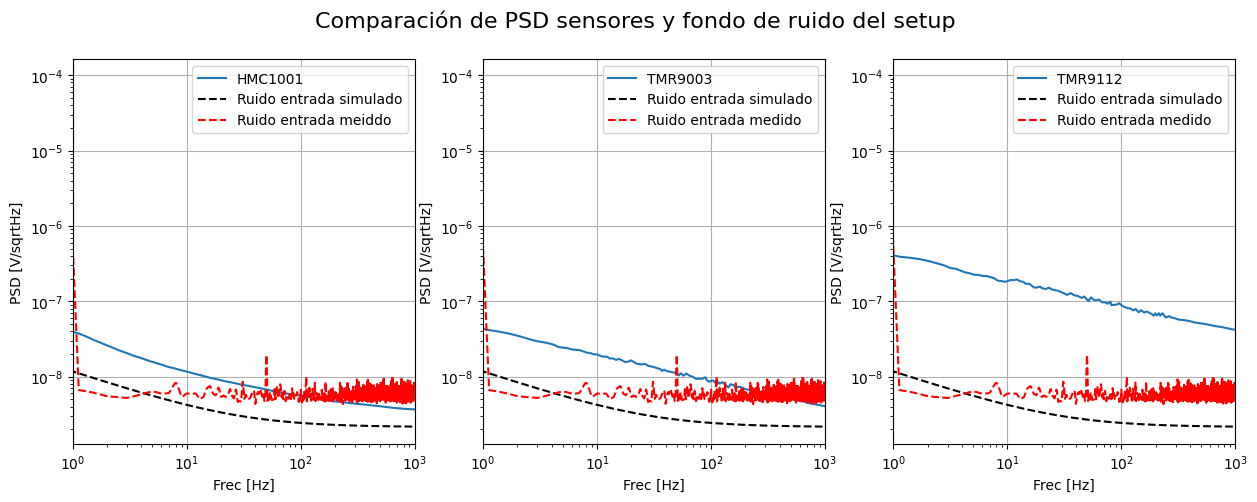

In [19]:
# Create a new figure
fig = plt.figure()

# Add a subplot
fig, ax = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns, and custom figure size

# Plot data for first sensor
ax[0].plot(common_freqs, HMC1001_aligned, label='HMC1001')
ax[0].plot(common_freqs, VinTheorSim_aligned, color='k', linestyle="dashed", label='Ruido entrada simulado')
ax[0].plot(common_freqs, HMC1001_Noisefloor, color='r', linestyle="dashed", label='Ruido entrada meiddo')

# Plot data for second sensor
ax[1].plot(common_freqs, TMR9003_aligned, label='TMR9003')
ax[1].plot(common_freqs, VinTheorSim_aligned, color='k', linestyle="dashed", label='Ruido entrada simulado')
ax[1].plot(common_freqs, TMR9003_Noisefloor, color='r', linestyle="dashed", label='Ruido entrada medido')

# Plot data for third sensor
ax[2].plot(common_freqs, TMR9112_aligned, label='TMR9112')
ax[2].plot(common_freqs, VinTheorSim_aligned, color='k', linestyle="dashed", label='Ruido entrada simulado')
ax[2].plot(common_freqs, TMR9112_Noisefloor, color='r', linestyle="dashed", label='Ruido entrada medido')

# Set a title for the whole figure
fig.suptitle('Comparación de PSD sensores y fondo de ruido del setup', fontsize=16)

for i in range(0, 3):
    # Log plot
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')

    # Customize the plot
    ax[i].set_xlabel('Frec [Hz]')
    ax[i].set_ylabel('PSD [V/sqrtHz]')
    ax[i].grid()
    ax[i].set_xlim(1, 1000)

    ax[i].legend()

# Display the figure
plt.show()